## ToF simulation
This is a small project to simulate the signal evolution for ToF angiography. To that end, the change in magnetization is computed numerically in an iterative fashion for a voxel with a single vessel surrounded by static tissue. Thus, no steady state conditions are used, the user has to specify the number of pulses experienced by the static tissue and blood. The parameters and code are explained later.

Currently the simulation supports the use of:
- blood delivery time (as proposed by Saskia) to account for signal saturation of the blood before entering the voxel
- vessel-within-voxel-fraction to account for the fact that a voxel might only cover part of the vessel volume
- plotting intra-voxel signal intensities of the different magnetization pools

### Assumptions
- isotrpic voxels (same edge length in x, y, and z)
- a single vessel per voxel
- a vessel is approximated as a cylinder
- constant blood velocity within the voxel (plug flow)
- vessel oriented parallel to voxel edge and has the same length as the voxel (although the later could be changed easily if required)
- within the voxel, a constant number of vessel segments / blood pools exist. Each pool has experienced a fixed number of excitations. The size of the segments is defined by the blood velocity and voxel/vessel length.

In [1]:
# import required packages
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt


## Code / Implementation
Here comes the code in form of a few classes (for simulation) and functions (for plotting). 

For examples and explaination of the code skip to the next sections

In [2]:
class GREMagPool:
    """this is the magnetization pool base class"""

    def __init__(self, tr=None, te=None, t1=None, t2s=None, mz_start=None, fa=None, n=None):
        # set variables or use defaults
        self.TR = tr if tr is not None else 20
        self.TE = te if te is not None else 6
        self.T1 = t1 if t1 is not None else 2000
        self.T2s = t2s if t2s is not None else 20
        self.MzStart = mz_start if mz_start is not None else 1.0
        self.FA = fa if fa is not None else 10
        self.N = n if n is not None else 100

        # checks for TE & TR
        if self.TE > self.TR:
            self.TE = self.TR
        if self.TR == 0:
            self.TR = 1

        # define "output" variables
        self.MzCurrent = self.MzStart
        self.MxyCurrent = self.__calc_mxy(self.TE)

    def __calc_mz(self, t=None, mz=None):
        if t is None:
            t = self.TR
        if mz is None:
            mz = self.MzCurrent
        e1 = np.exp(-t/self.T1)
        return mz * np.cos(np.deg2rad(self.FA)) * e1 + 1 - e1

    def __calc_mxy(self, t=None, mz=None):
        if t is None:
            t = self.TE
        if mz is None:
            mz = self.MzCurrent
        e2s = np.exp(-t/self.T2s)
        return mz * np.sin((np.deg2rad(self.FA))) * e2s

    def calc_mag_after_n_pulses(self):
        # returns for longitudinal magnetization the state prior to each pulse/before excitation
        # returns for transversal magnetization the state at TE
        mz = np.zeros(self.N)
        mz[0] = self.MzStart
        for i in range(1, self.N):
            mz[i] = self.__calc_mz(self.TR, mz[i - 1])
        self.MzCurrent = mz[-1]
        self.MxyCurrent = self.__calc_mxy(t=self.TE)
        return mz    

class GREVesselMagPools:
    """this class simulates the different mag pools/signals a vessels has due to different inflow enhancement"""
    def __init__(self, tr=None, te=None, t1=None, t2s=None, fa=None, n_prior_pulses=None,
                 vessel_len_mm=None, blood_velocity_mm_s=None):
        # set variables or use defaults
        self.TR = tr if tr is not None else 20
        self.TE = te if te is not None else 6
        self.T1 = t1 if t1 is not None else 2000
        self.T2s = t2s if t2s is not None else 20
        self.FA = fa if fa is not None else 10
        # number of pulses the blood experienced before entering the voxel of interest (aka pulses during delivery time)
        self.NPriorPulses = n_prior_pulses if n_prior_pulses is not None else 10
        # vessel length in mm
        self.VesselLen = vessel_len_mm if vessel_len_mm is not None else 1
        # blood velocity in mm/s
        self.BloodVelocity = blood_velocity_mm_s if blood_velocity_mm_s is not None else 1

        # compute the number of blood vessel magnetization pools
        self.NPools = self.__calc_number_of_pools()
        # compute vessel segment lengths
        self.SegLen = self.__calc_vessel_segment_lengths()

    def __calc_number_of_pools(self):
        # compute the number of blood vessel magnetization pools
        # FYI: convert TR from ms to s
        n_float = self.VesselLen / (self.BloodVelocity * self.TR * 0.001)
        # if an integer number of pools/segments was found we are lucky
        if n_float % 1.0 == 0.0:
            n = int(n_float)
        else:
            # else, there are n pools of length <Velocity * TR> plus 1 pool of the length VesselLen - LengthFullSegments
            n = int(np.floor(n_float)) + 1
        return n

    def __calc_vessel_segment_lengths(self):
        # FYI: convert TR from ms to s
        full_seg_len = self.BloodVelocity * self.TR * 0.001
        # single segment cannot be longer than vessel itself
        if full_seg_len > self.VesselLen:
            full_seg_len = self.VesselLen
        # init array with all the lengths
        seg_len = np.zeros(self.NPools)
        # trivial case: 1 segment only
        if full_seg_len == self.VesselLen:
            seg_len[0] = full_seg_len
        else:
            # the first [0] to second to last segment [NPools-1] have the full segment length
            for i in range(0, self.NPools-1):
                seg_len[i] = full_seg_len
            # the last segment [NPools-2] has the remaining length of <VesselLen-(NPools-1)*FullSegLen>
            seg_len[-1] = self.VesselLen - (self.NPools-1)*full_seg_len

        return seg_len

    def calc_weighted_vessel_mag(self):
        # compute the number of blood vessel magnetization pools
        self.NPools = self.__calc_number_of_pools()
        # compute vessel segment length
        self.SegLen = self.__calc_vessel_segment_lengths()
        # compute the transversal mag for each vessel segment / pool
        # first set up a magnetization pool instance with the proper parameters
        mag_pool = GREMagPool(tr=self.TR, te=self.TE, t1=self.T1, t2s=self.T2s, mz_start=1.0, fa=self.FA, n=0)
        # now compute the magnetization per pool
        # each pool has seen NPriorPulses plus pulses within the voxel
        # the number of pulses within the voxel range from 1 (first segment) to NPools (last segment)
        mag_per_pool = np.zeros([self.NPools])
        for i in range(0, self.NPools):  # hm: this loop could be unrolled if MxyHistory would be returned by GREMagPool
            # set number of all pulses experienced by this blood pool (<+1> to account for very first excitation)
            mag_pool.N = self.NPriorPulses + i + 1
            # calc magnetization
            mag_pool.calc_mag_after_n_pulses()
            # copy Mxy results
            mag_per_pool[i] = mag_pool.MxyCurrent
        # last, weight the magnetization per pool/segment with its relative length (proportional to volume)
        weighted_mag = np.sum(np.multiply(mag_per_pool, self.SegLen)/self.VesselLen)
        return weighted_mag, mag_per_pool


class FRE:
    """this class simulates the flow-related enhancement"""
    def __init__(self, tr=None, te=None, fa=None, n_dummies=None, voxel_length_mm=None,
                 t1_blood=None, t2s_blood=None, vessel_diameter_mm=None, blood_delivery_time_s=None,
                 vessel_in_voxel_fraction=None, blood_velocity_mm_s=None,
                 t1_tissue=None, t2s_tissue=None):
        # set variables or use defaults
        # sequence parameters: TR, TE, flip angle (FA), number of dummy shots (n_dummies)
        self.TR = tr if tr is not None else 20
        self.TE = te if te is not None else 4
        self.FA = fa if fa is not None else 18
        self.NDummies = n_dummies if n_dummies is not None else 100

        # voxel parameters: voxel volume = (voxel length)^3 --> isotropic voxel assumed
        self.VoxelLen = voxel_length_mm if voxel_length_mm is not None else 1.0  # in mm
        if self.VoxelLen == 0:
            self.VoxelLen = 0.001  # in mm --> 1 um

        # blood parameters
        self.T1Blood = t1_blood if t1_blood is not None else 2100  # in ms
        self.T2sBlood = t2s_blood if t2s_blood is not None else 62  # in ms
        self.VesselDiameter = vessel_diameter_mm if vessel_diameter_mm is not None else 0.25  # in mm
        # time the blood spends in the slab before entering the voxel of interest
        self.BloodDeliveryTime = blood_delivery_time_s if blood_delivery_time_s is not None else 1.0  # in s
        # fraction of the vessel within the voxel; account for vessels only partially inside voxel
        self.VesselInVoxelFraction = vessel_in_voxel_fraction if vessel_in_voxel_fraction is not None else 1.0  # [0..1]
        # blood velocity within the voxel
        self.BloodVelocity = blood_velocity_mm_s if blood_velocity_mm_s is not None else 1.0  # in mm/s

        # tissue parameters
        self.T1Tissue = t1_tissue if t1_tissue is not None else 1250  # in ms
        self.T2sTissue = t2s_tissue if t2s_tissue is not None else 40  # in ms

        # set sizes and compute volumes
        self.VesselLen = self.VoxelLen  # assume orthogonal vessel through voxel with same length
        self.VoxelVol = self.__calc_voxel_volume()
        self.VesselVol = self.__calc_vessel_volume()
        self.TissueVol = self.__calc_tissue_volume()

        # calculate the number of pulses experienced by the blood during the blood delivery time;
        # thus, the time the blood spend in the slab before entering the voxel of interest
        self.NPriorPulses = self.__calc_num_prior_pulses()

        # check the number of dummies:
        # the tissue has experienced at least NPriorPulses
        if self.NDummies < self.NPriorPulses:
            self.NDummies = self.NPriorPulses
        # or at least one pulse in case of full in-flow replacement per TR aka NPriorPulses = 0
        if self.NDummies == 0:
            self.NDummies = 1

        # init magnetization of tissue and blood pools; these are used ie for plotting
        self.MagTissue = 0.0
        self.MagAvgBlood = 0.0
        self.MagsBlood = np.array([])

        # store blood segment lengths; also required for plots
        self.SegLen = np.array([])

    def __calc_voxel_volume(self):
        return np.power(self.VesselLen, 3)

    def __calc_vessel_volume(self):
        # volume of the vessel cylinder
        vessel_vol = np.pi * np.power(self.VesselDiameter/2, 2) * self.VesselDiameter
        # vessel volume should NOT exceed voxel volume
        if vessel_vol > self.VoxelVol:
            vessel_vol = self.VoxelVol
        # now account for vessel fraction factor
        vessel_vol = vessel_vol * self.VesselInVoxelFraction
        return vessel_vol

    def __calc_tissue_volume(self):
        return self.VoxelVol - self.VesselVol

    def __calc_num_prior_pulses(self):
        # number of pulses blood experienced before entering the voxel is DeliveryTime/TR
        # FYI: convert TR from ms to s
        return int(np.floor(self.BloodDeliveryTime/(0.001*self.TR)))

    def calc_fre(self):
        # update volumes and lengths
        self.VesselLen = self.VoxelLen  # assume orthogonal vessel through voxel with same length
        self.VoxelVol = self.__calc_voxel_volume()
        self.VesselVol = self.__calc_vessel_volume()
        self.TissueVol = self.__calc_tissue_volume()

        # update number of pulses blood experienced before entering the voxel of interest
        self.NPriorPulses = self.__calc_num_prior_pulses()

        # calc tissue magnetization
        tissue_pool = GREMagPool(self.TR, self.TE, self.T1Tissue, self.T2sTissue, mz_start=1.0, fa=self.FA,
                                 n=self.NDummies)
        tissue_pool.calc_mag_after_n_pulses()
        self.MagTissue = tissue_pool.MxyCurrent

        # calc vessel magnetization
        vessel_pool = GREVesselMagPools(self.TR, self.TE, self.T1Blood, self.T2sBlood, self.FA,
                                        n_prior_pulses=self.NPriorPulses, blood_velocity_mm_s=self.BloodVelocity,
                                        vessel_len_mm=self.VesselLen)
        self.MagAvgBlood, self.MagsBlood = vessel_pool.calc_weighted_vessel_mag()
        self.SegLen = vessel_pool.SegLen

        # calc relative FRE
        rel_fre = self.MagAvgBlood/self.MagTissue

        # calc volume-weighted FRE = VoxelVol * (VesselMag * VesselVol)/(TissueMag * TissueVol)
        # quasi intra-voxel, volume-weighted FRE
        # FYI: add epsilon to account for potential zero tissue volume
        vol_weighted_fre = \
            (self.VoxelVol*self.MagAvgBlood*self.VesselVol)/(self.MagTissue*self.TissueVol+np.finfo(float).eps)

        # calc voxel magnetization
        voxel_mag = (self.MagAvgBlood*self.VesselVol + self.MagTissue*self.TissueVol)/self.VoxelVol

        # calc volume-weighted voxel magnetization = (VoxelMag * VoxelVolume) / 1mm^3
        vol_weighted_voxel_mag = voxel_mag * self.VoxelVol

        return rel_fre, vol_weighted_fre, voxel_mag, vol_weighted_voxel_mag
    
    
def plot_fre_voxel(fre, size_pixel=None):
    # init
    size = size_pixel if size_pixel is not None else 256

    # compute scaling factor to convert from mm to pixel
    scaling = size/fre.VoxelLen

    # create figure
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plot voxel as rectangle with tissue intensity
    rect_voxel = Rectangle((0, 0), size, size, color=(fre.MagTissue, fre.MagTissue, fre.MagTissue))
    ax.add_patch(rect_voxel)

    # plot vessel segments
    # first set y position and size aka height
    vessel_height = np.round(scaling*fre.VesselDiameter)
    vessel_pos_y = np.round(size/2 - vessel_height/2)
    for i in range(0, len(fre.SegLen)):
        # for each segment find x position and size aka width
        vessel_width = scaling * fre.SegLen[i]
        vessel_pos_x = scaling * fre.SegLen[0] * i  # use the first segment, otherwise problems for the "remainder" seg

        # plot the segment
        rect_segment = Rectangle((vessel_pos_x, vessel_pos_y), vessel_width, vessel_height,
                                 color=(fre.MagsBlood[i], fre.MagsBlood[i], fre.MagsBlood[i]))
        ax.add_patch(rect_segment)

    plt.xlim([0, size])
    plt.ylim([0, size])
    plt.show()

    # todo: volume or diameter adjusted plottng; scalling of voxel intensities from [min max] or [0 1]; voxel fraction thingy


def plot_fre_heatmap(data, xticks, yticks, plot_title, label_x_axis=None, label_y_axis=None):
    # init figure
    label_x_axis = label_x_axis if not None else ''
    label_y_axis = label_y_axis if not None else ''
    
    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap='gray')

    # set ticks
    # we want to show all ticks...
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_yticks(np.arange(len(yticks)))
    # ... and label them with the respective list entries; FYI truncate ticklabels
    ax.set_xticklabels(np.around(xticks, decimals=2))
    ax.set_yticklabels(np.around(yticks, decimals=2))

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fig.colorbar(im)
    ax.set_title(plot_title)
    plt.xlabel(label_x_axis)
    plt.ylabel(label_y_axis)
    #fig.tight_layout()
    plt.show()

## Code explanation and examples
The user only needs to make two calls for a simple simulation.
1. Create a class instance
2. Run the simulation

While creating the class instance all parameters used can be specified, but can also be changed afterwards. The parameters are: 
- TR in ms
- TE in ms
- flip angle (fa) in degrees
- relaxation times T1 and T2* for blood in ms
- relaxation times T1 and T2* for static tissue in ms
- voxel length in mm (this value is reused as the vessel length)
- vessel diameter in mm
- vessel in voxel fraction [0..1]: how much of the vessel volume is within the voxel? 1 == 100%
- blood velocity in mm/s
- blood delivery time in s (as proposed by Saskia): how long did the blood travel trough the slab before entering the voxel of interest? by dividing the delivery time with TR we get the number of exciations the blood experienced before entering the voxel
- number of dummy pulses (n_dummies): how many excitations did the static tissue within the voxel experience prior to this simulation?

The simulation computes the number of vessel segments automatically and treats each magnetization pool (vessel segments and tissue) seperately. Magnetizations are combined as volume-weighted sums and abbreviated with $M$.

After initializing the class, the simulation can be run using '''.calc_fre''' which returns the following metrics:
- relative FRE (flow related enhancement) computed as $\frac{M_{blood}}{M_{tissue}}$
- volume-weighted, relative FRE computed as  computed as $V_{voxel} \frac{M_{blood} V_{blood}}{M_{tissue} V_{tissue}}$. 
- voxel magnetization computed as the volume-weighted sum of all magnetization pools $M_{voxel} = \frac{1}{V_{voxel}} \sum_i^n M_i V_i$
- volume-weighted voxel magnetization as $\frac{M_{voxel} V_{voxel}}{1 mm^3} = \frac{1}{1 mm^3} \sum_i^n M_i V_i$ $

The volume-weighting is used to penalized small volumes by (foolishly) approximating availible SNR with the volume itselt. Not working too well...


In [3]:
Voxel1 = FRE(tr=20, te=10, fa=40, n_dummies=1000, voxel_length_mm=0.50,
             t1_blood=2000, t2s_blood=60, vessel_diameter_mm=0.25, vessel_in_voxel_fraction=1.0,
             blood_delivery_time_s=0.0, blood_velocity_mm_s=6.0,
             t1_tissue=1600, t2s_tissue=40)
RelFRE, VolWeightedFRE, VoxelMag, VolWeightedVoxelMag = Voxel1.calc_fre()

### Visualize the voxel

This is a (work-in-progress) plot function to see how the signal within the voxel looks like. We can see that (within the voxel) there are several vessel segments with different signal intensity. All segments have the length $\frac{v_{blood}}{TR}$, expect for the last (most right) segment.



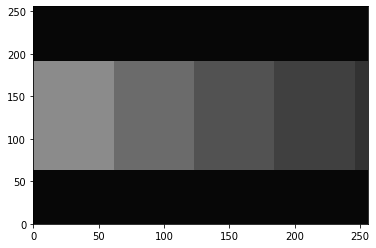

In [4]:
plot_fre_voxel(Voxel1)

Now we use a smaller vessel diameter and increase the blood delivery time. Note how the signal intensity of the blood is reduced due to the delivery time (not the diameter).

FYI: the vessel diameter (not volume) is used to scale the size of the vessel in the plot. The vessel-in-volume-fraction is currently only used in the simulation and not supported in the plot.

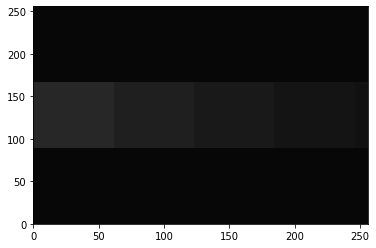

In [5]:
Voxel1.VesselDiameter = 0.15  # mm
Voxel1.BloodDeliveryTime = 0.1  # s
Voxel1.calc_fre()
plot_fre_voxel(Voxel1)

Finally, increase the blood velocity to get a full in-flow replacement and set the delivery time again to zero

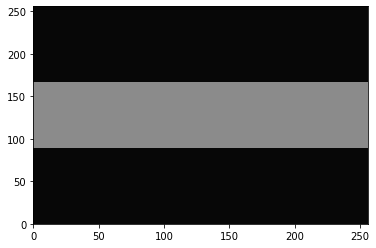

In [6]:
Voxel1.BloodDeliveryTime = 0.0  # s
Voxel1.BloodVelocity = 100  # mm/s
Voxel1.calc_fre()
plot_fre_voxel(Voxel1)

## Compare impact of delivery time and blood velocity
We keep the voxel size (0.25mm iso), vessel diameter (0.2mm), and flip angle (18 degrees) constant and test the effect of different velocities and delivery time on the relative FRE = $\frac{M_{blood}}{M_{tissue}}$

Note that the effect of the delivery time is much stronger than the blood velocity within the voxel (as Saskia already pointed out). Nevertheless, this means a good trade-off between slab thickness (prop. to SNR) and delivery time (prop. to CNR) as to be found.

FYI: Code is not optimized yet, takes some time...

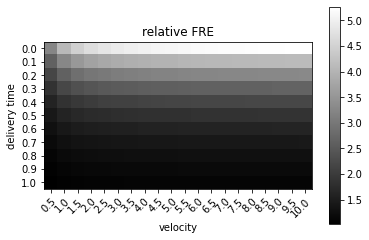

In [7]:
Voxel1.FA = 18
Voxel1.VoxelLen = 0.25
Voxel1.VesselDiameter = 0.20
Voxel1.VesselInVoxelFraction = 1.0
velocities = np.arange(0.5, 10.5, 0.5)
delivery_times = np.arange(0.0, 1.1, 0.1)
rel_fre = np.zeros([len(delivery_times), len(velocities)])

for j in range(0, len(velocities)):
    for i in range(0, len(delivery_times)):
        Voxel1.BloodVelocity = velocities[j]
        Voxel1.BloodDeliveryTime = delivery_times[i]
        rel_fre[i, j], _, _, _ = Voxel1.calc_fre()

plot_fre_heatmap(rel_fre, velocities, delivery_times, 'relative FRE', 'velocity', 'delivery time')


## Compare vessel diameter against voxel size
The voxel magnetization shows meaningful results.
The relative FRE is insensitive to volume changes as it is compute only as the ratio of blood to tissue magnetization.

Note: For voxels smaller than 0.2mm iso there is full inflow replacement. The volmue-weighted metrics are not plotted as they are not really useful...


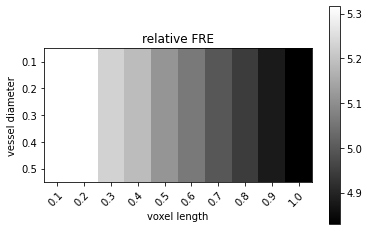

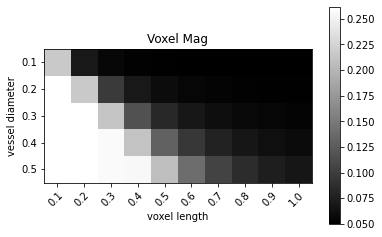

In [8]:
Voxel1.BloodDeliveryTime = 0.0
Voxel1.BloodVelocity = 10.0

voxel_lens = np.arange(0.1, 1.1, 0.1)
vessel_diameters = np.arange(0.1, 0.6, 0.1)
rel_fre = np.zeros([len(vessel_diameters), len(voxel_lens)])
vw_rel_fre = np.zeros([len(vessel_diameters), len(voxel_lens)])
voxel_mag = np.zeros([len(vessel_diameters), len(voxel_lens)])
vw_voxel_mag = np.zeros([len(vessel_diameters), len(voxel_lens)])
for j in range(0, len(voxel_lens)):
    for i in range(0, len(vessel_diameters)):
        Voxel1.VoxelLen = voxel_lens[j]
        Voxel1.VesselDiameter = vessel_diameters[i]
        rel_fre[i, j], vw_rel_fre[i, j], voxel_mag[i, j], vw_voxel_mag[i, j] = Voxel1.calc_fre()

plot_fre_heatmap(rel_fre, voxel_lens, vessel_diameters, 'relative FRE', 'voxel length', 'vessel diameter')
plot_fre_heatmap(voxel_mag, voxel_lens, vessel_diameters, 'Voxel Mag', 'voxel length', 'vessel diameter')


## Check the influence of vessel-in-voxel-fraction
Usually, the vessel and voxel do not align perfectly. This is modeled with the fraction parameter. Note how smaller voxels are beneficial to reduce this (but could also cause vessel diameters to be overestimated).

A contrast vessel diameter of 0.20mm is used.

Note: Treating the problem with a relative fraction is easy to simulate. Nevertheless, it distorts the perception of the problem if the vessel volume is larger than the voxel volume. In this case, the current strategy is to first set the vessel volume to the voxel volume and then accound for the fraction (see calc_vessel_volume()). 

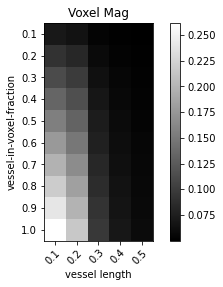

In [9]:
Voxel1.BloodDeliveryTime = 0.0
Voxel1.BloodVelocity = 10.0
Voxel1.VesselDiameter = 0.20

voxel_lens = np.arange(0.1, 0.6, 0.1)
vessel_fraction = np.arange(0.1, 1.1, 0.1)
rel_fre = np.zeros([len(vessel_fraction), len(voxel_lens)])
voxel_mag = np.zeros([len(vessel_fraction), len(voxel_lens)])
for j in range(0, len(voxel_lens)):
    for i in range(0, len(vessel_fraction)):
        Voxel1.VoxelLen = voxel_lens[j]
        Voxel1.VesselInVoxelFraction = vessel_fraction[i]
        _, _, voxel_mag[i, j], _ = Voxel1.calc_fre()

plot_fre_heatmap(voxel_mag, voxel_lens, vessel_fraction, 'Voxel Mag', 'vessel length', 'vessel-in-voxel-fraction')